In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from Sequence import sequence
from directional_accuracy import calculate_directional_accuracy


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Data imports from Yahoo Finance and Fedral Reserve Economic Data (fred).

In [ ]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2020-01-01'
sequence_length = 30

data = yf.download(ticker, start=start_date, end=end_date)
gdp = web.DataReader('GDP', 'fred', start_date, end_date) #GDP for each quarter
cpi = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
unemployment = web.DataReader('UNRATE', 'fred', start_date, end_date)
interest_rates = web.DataReader('FEDFUNDS', 'fred', start_date, end_date)

close_data = data[['Close']]

Data Processing for incorporating Macroeconomic Data. 

In [3]:
def sequence_macro(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :]) 
        y.append(data[i, 0])  

    return np.array(X), np.array(y)
#concat and resample
#EDIT HERE TO CHOOSE DIFFERENT MACRO ECONOMIC INPUTS
external_data = pd.concat([cpi, unemployment, interest_rates], axis=1)
external_data = external_data.resample('D').ffill() #This will give us this data from each day

#Merging with stock prices
combined_data = pd.concat([close_data, external_data], axis=1).dropna() 
combined_data.columns = ['Close Price', 'CPI', 'Unemployment', 'Interest Rate']

#Must split the data before creating sequences & scaling to prevent leaks
min_test_size = sequence_length + 1

#edge case with data:
if len(combined_data) <= sequence_length + 1:
    raise ValueError("The dataset is too small for the chosen sequence length. Reduce sequence_length or use more data.")

train_size = int(0.8 * len(combined_data))
train_data = combined_data[:train_size]
test_data = combined_data[train_size:]


#scaling - fit scale to training then apply to test
scale = MinMaxScaler(feature_range=(0,1))
scaled_train_data = scale.fit_transform(train_data)
scaled_test_data = scale.transform(test_data)


#create the sequences - using sequence_macro
x_train, y_train = sequence_macro(scaled_train_data, sequence_length)
x_test, y_test = sequence_macro(scaled_test_data, sequence_length)
print(f"Training data shape: X={x_train.shape}, y={y_train.shape}")
print(f"Testing data shape: X={x_test.shape}, y={y_test.shape}")

Training data shape: X=(976, 30, 4), y=(976,)
Testing data shape: X=(222, 30, 4), y=(222,)


Model Specifications

In [4]:

model = tf.keras.models.Sequential([

    tf.keras.Input(shape=(x_train.shape[1], x_train.shape[2])),
    tf.keras.layers.LSTM(units=100, return_sequences=True),
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.LSTM(units=100, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(units=1, kernel_regularizer=tf.keras.regularizers.l2(0))
])

#model.compile(optimizer='adam', loss='mean_squared_error')
model.compile(optimizer='adam', loss=tf.keras.losses.Huber())

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=5,            # Stop after 5 epochs of no improvement
    restore_best_weights=True  # Restore weights from the best epoch
)
model.fit(x_train, y_train, epochs = 50, batch_size=16, validation_split=0.2, verbose=1, callbacks=[early_stopping])


#data shaping with extra data
predicted_prices = model.predict(x_test)
predicted_prices_full_stack = np.hstack((
    predicted_prices,
    np.zeros((predicted_prices.shape[0], scaled_train_data.shape[1] - 1))
))
predicted_prices = scale.inverse_transform(predicted_prices_full_stack)[:, 0]

actual_prices_full_stack = np.hstack((

    y_test.reshape(-1,1),
    np.zeros((y_test.shape[0], scaled_train_data.shape[1] - 1))
))
actual_prices = scale.inverse_transform(actual_prices_full_stack)[:,0]


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0080 - val_loss: 0.0030
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - val_loss: 0.0045
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.4550e-04 - val_loss: 0.0024
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.7065e-04 - val_loss: 0.0027
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.5364e-04 - val_loss: 0.0026
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.9176e-04 - val_loss: 0.0026
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 7.2780e-04 - val_loss: 0.0019
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 7.0665e-04 - val_loss: 0.0054
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 7.5172e-04 - val_loss: 0.0020
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 6.9055e-04 - val_loss: 0.0022
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 7.6931e-04 - val_loss: 0.0021
Epoch 12/50
49/49 ━━━━━━━━━

RMSE and Directional Accuracy analysis & Visual

Test AAPL RMSE: 3.5309141769523635
Test AAPL Directional Accuracy: 57.9185520361991%


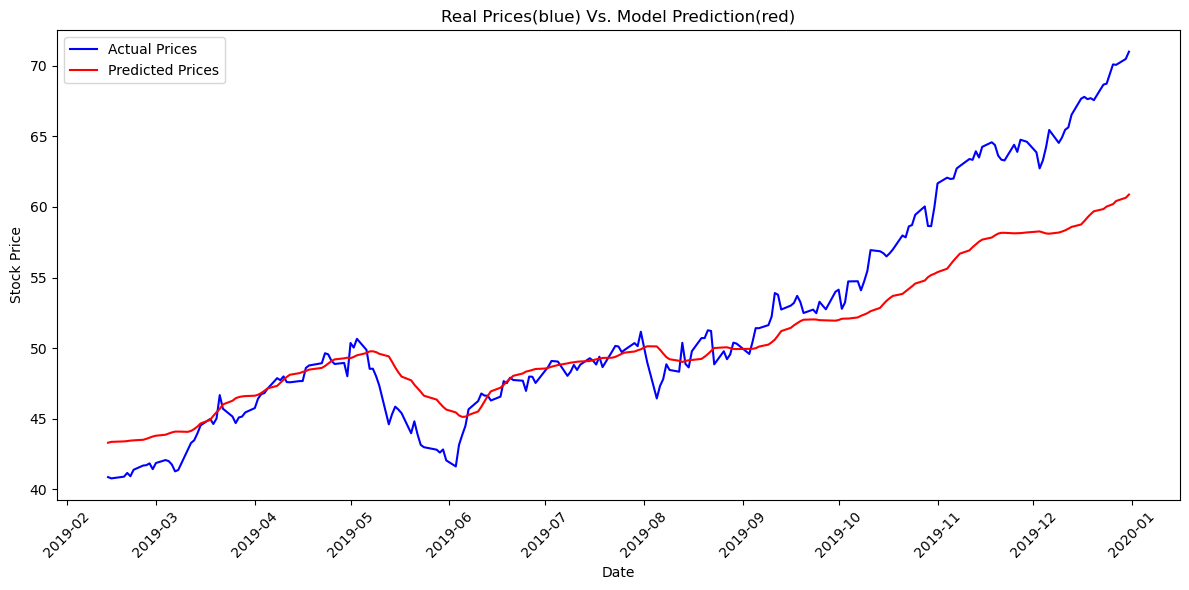

In [5]:
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))


print(f"Test {ticker} RMSE: {rmse}")

direction_accuracy = calculate_directional_accuracy(actual_prices, predicted_prices)
print(f"Test {ticker} Directional Accuracy: {direction_accuracy}%")

test_dates = data.index[-len(actual_prices):]


plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_prices, label="Actual Prices", color="blue")
plt.plot(test_dates, predicted_prices, label="Predicted Prices", color="red")
plt.title("Real Prices(blue) Vs. Model Prediction(red)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Macro plot")
plt.show()